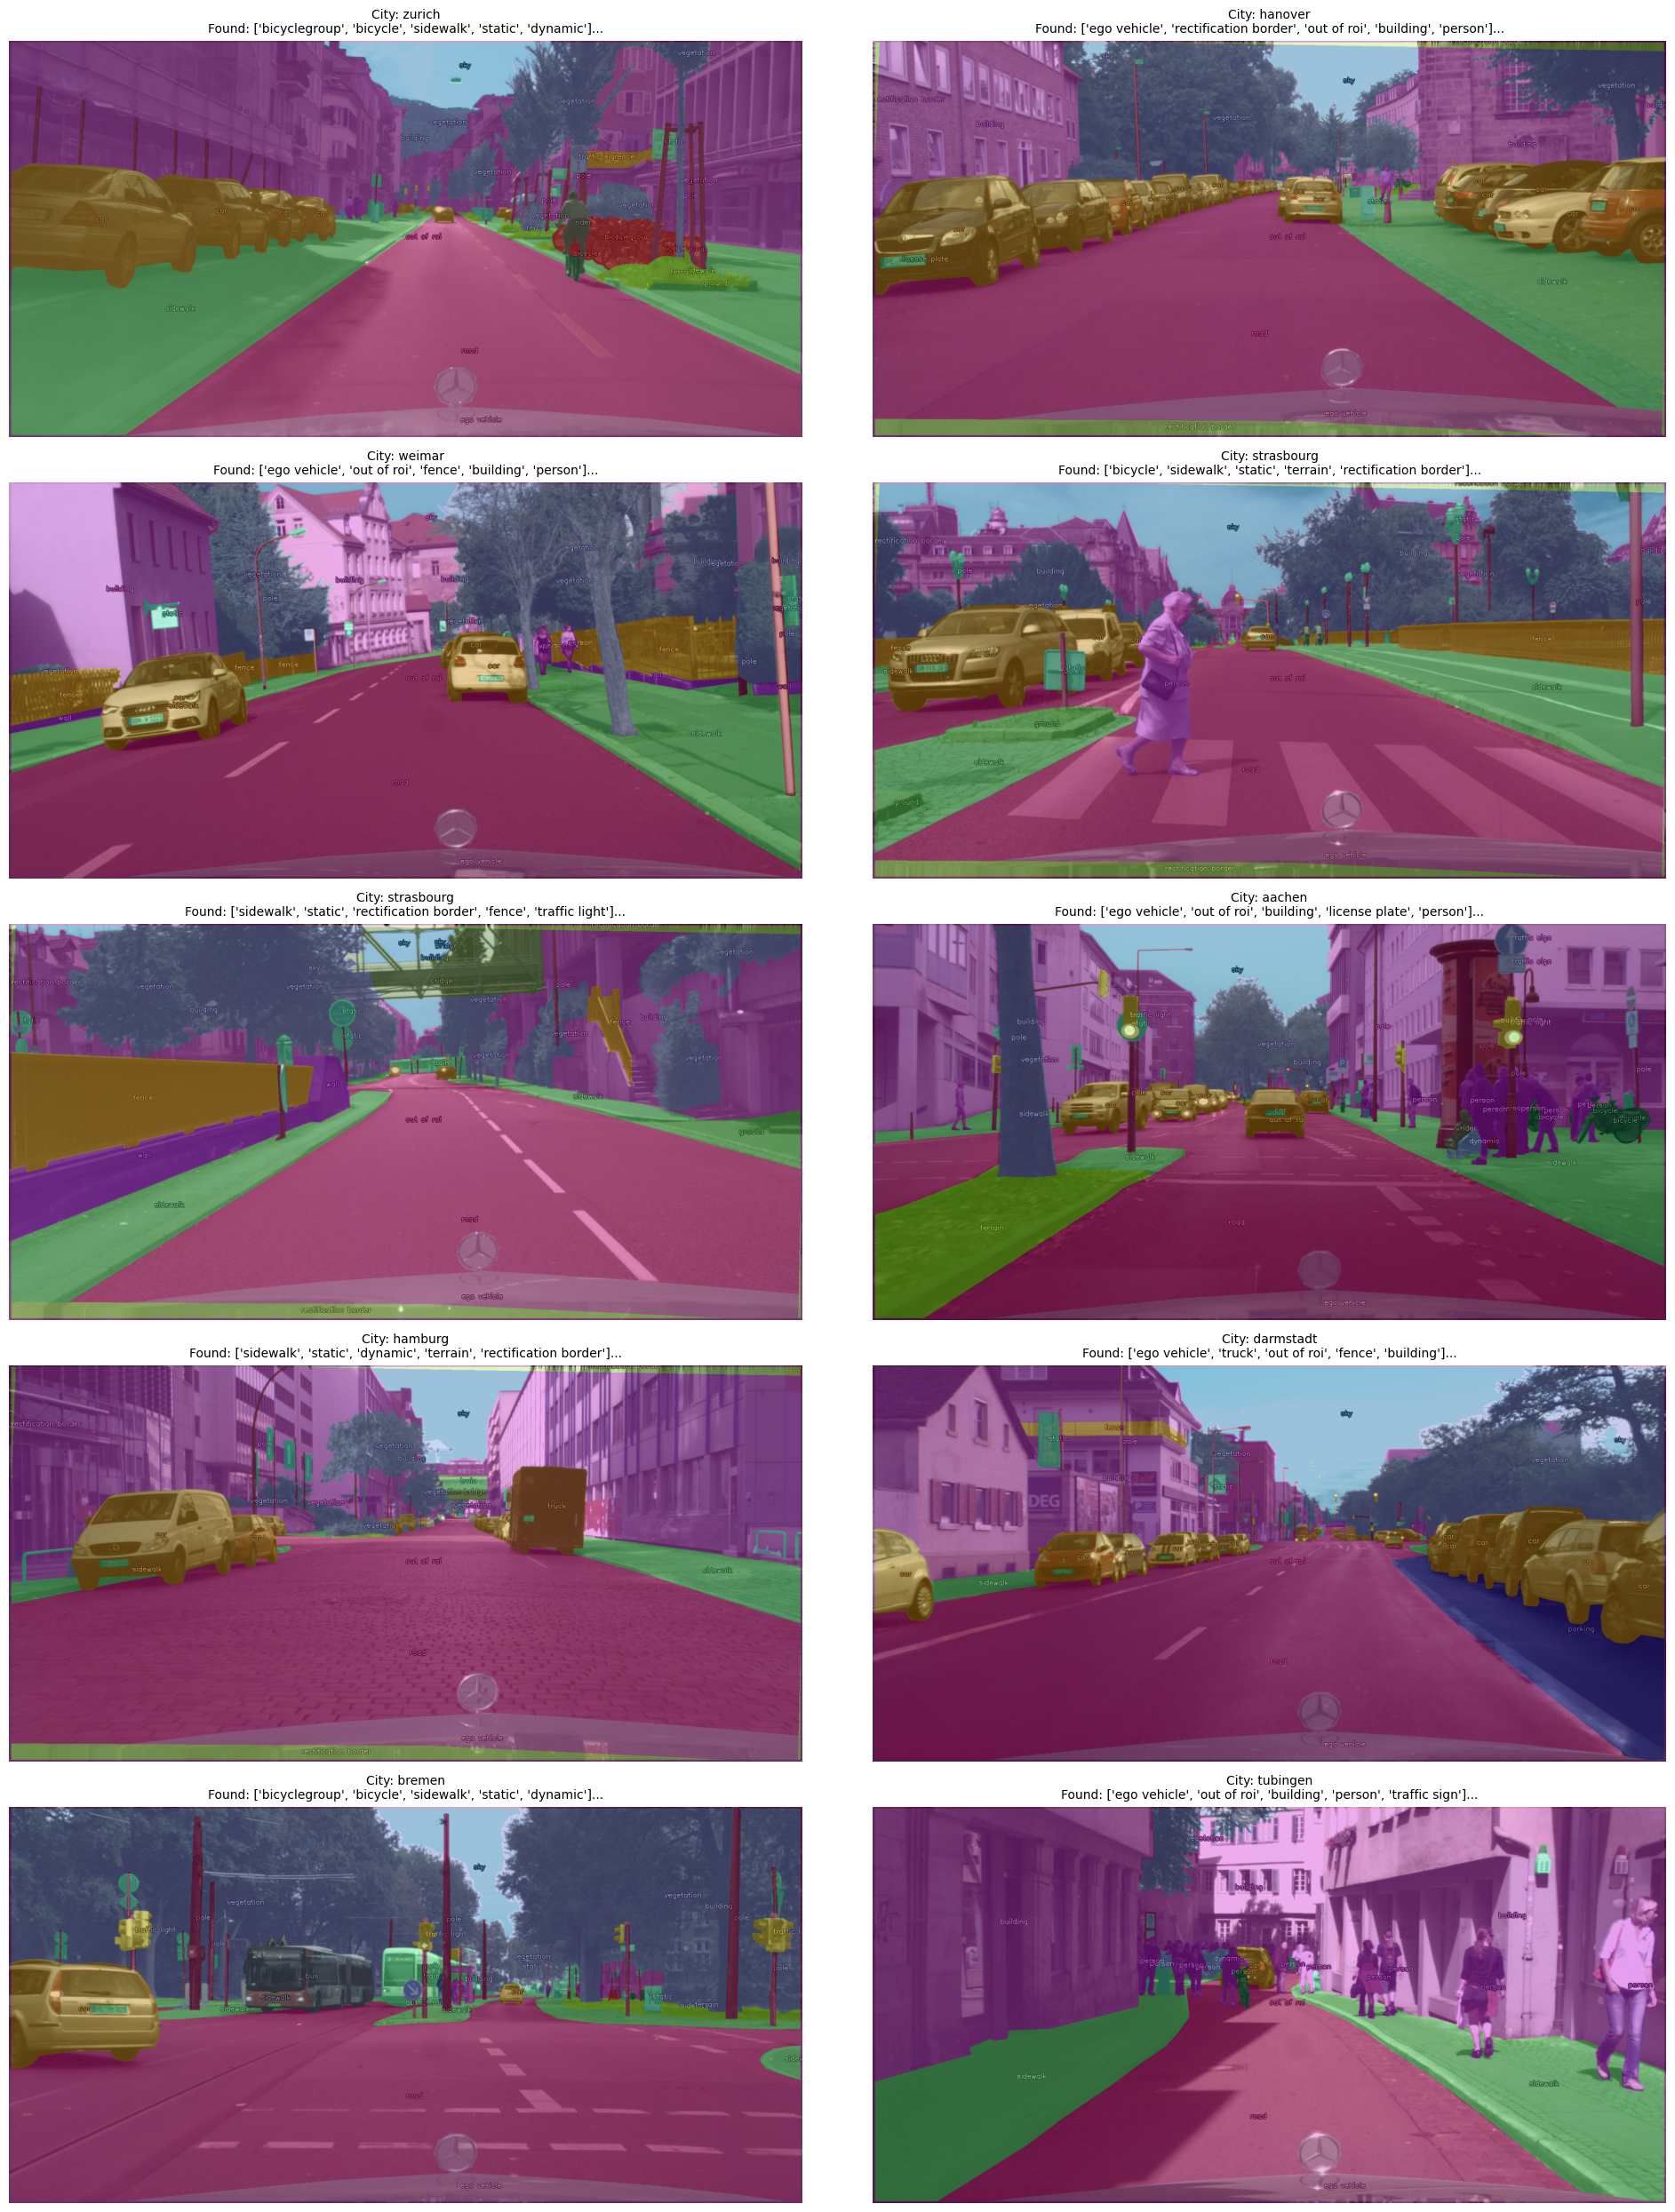

In [1]:
import json
import cv2
import os
import glob
import matplotlib.pyplot as plt
import numpy as np
import random

def visualize_grid(img_dir, json_dir, num_images=10, cols=2):
    """
     function to visualize a grid of images with auto-extracted labels from JSON.
    
    Args:
        img_dir (str): Path to the folder containing image subfolders (e.g., leftImg8bit/train)
        json_dir (str): Path to the folder containing JSON subfolders (e.g., gtFine/train)
        num_images (int): Total images to show.
        cols (int): Number of columns in the grid.
    """
    
    # 1. Gather all image paths
    # We look for all .png files recursively inside the city folders
    all_img_paths = glob.glob(os.path.join(img_dir, "*", "*_leftImg8bit.png"))
    
    if len(all_img_paths) == 0:
        print("No images found! Check your paths.")
        return

    # 2. Select random images
    selected_paths = random.sample(all_img_paths, min(len(all_img_paths), num_images))
    
    # 3. Setup Plot
    rows = (num_images + cols - 1) // cols
    plt.figure(figsize=(10 * cols, 5 * rows))
    
    for i, img_path in enumerate(selected_paths):
        # --- PATH PARSING ---
        # Extract city and basename to find the matching JSON
       
        city = os.path.basename(os.path.dirname(img_path))
        filename = os.path.basename(img_path)
        
        # Construct JSON filename
        json_filename = filename.replace('_leftImg8bit.png', '_gtFine_polygons.json')
        json_path = os.path.join(json_dir, city, json_filename)
        
        # --- LOAD DATA ---
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        overlay = image.copy()
        
        unique_labels = set()
        
        if os.path.exists(json_path):
            with open(json_path, 'r') as f:
                data = json.load(f)
            
            
            for obj in data['objects']:
                label = obj['label']
                polygon = np.array(obj['polygon'])
                unique_labels.add(label)
                
               
                np.random.seed(abs(hash(label)) % (2**32 - 1))
                color = np.random.randint(0, 255, size=3).tolist()
                
               
                cv2.fillPoly(overlay, [polygon], color)
                
               
                if cv2.contourArea(polygon) > 2500: 
                    M = cv2.moments(polygon)
                    if M["m00"] != 0:
                        cX = int(M["m10"] / M["m00"])
                        cY = int(M["m01"] / M["m00"])
                        
                        cv2.putText(image, label, (cX, cY), cv2.FONT_HERSHEY_SIMPLEX, 
                                    0.6, (0, 0, 0), 3) 
                        cv2.putText(image, label, (cX, cY), cv2.FONT_HERSHEY_SIMPLEX, 
                                    0.6, (255, 255, 255), 1) 
        else:
            print(f"Warning: JSON not found for {filename}")

       
        alpha = 0.4
        cv2.addWeighted(overlay, alpha, image, 1 - alpha, 0, image)
        
        # --- PLOT ---
        plt.subplot(rows, cols, i + 1)
        plt.imshow(image)
        plt.title(f"City: {city}\nFound: {list(unique_labels)[:5]}...", fontsize=10)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# --- EXECUTE ---

IMG_SOURCE = '/kaggle/input/cityscape-dataset/Cityscape Dataset/leftImg8bit/train'
JSON_SOURCE = '/kaggle/input/cityscape-dataset/Fine Annotations/gtFine/train'

# Run the generic function
visualize_grid(IMG_SOURCE, JSON_SOURCE, num_images=10, cols=2)

In [2]:
import tensorflow as tf
import glob
import os

# --- 1. CONFIGURATION ---
IMG_HEIGHT = 256
IMG_WIDTH = 512
BATCH_SIZE = 8
NUM_CLASSES = 34 

# --- 2. PATHS ---
IMG_DIR = '/kaggle/input/cityscape-dataset/Cityscape Dataset/leftImg8bit/train'
MASK_DIR = '/kaggle/input/cityscape-dataset/Fine Annotations/gtFine/train'

print(f"Looking for images in: {IMG_DIR}")
print(f"Looking for masks in:  {MASK_DIR}")

img_paths = sorted(glob.glob(os.path.join(IMG_DIR, '*/*.png')))
mask_paths = sorted(glob.glob(os.path.join(MASK_DIR, '*/*_labelIds.png')))

print(f"Found {len(img_paths)} images.")
print(f"Found {len(mask_paths)} masks.")

# --- SANITY CHECK ---
if len(img_paths) != len(mask_paths):
    print("CRITICAL ERROR: Mismatch in number of images and masks!")
    min_len = min(len(img_paths), len(mask_paths))
    img_paths = img_paths[:min_len]
    mask_paths = mask_paths[:min_len]
    print(f"Truncated both lists to {min_len}")

# --- 3. LOAD FUNCTION ---
def load_data(img_path, mask_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, (IMG_HEIGHT, IMG_WIDTH))
    img = tf.cast(img, tf.float32) / 255.0 

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, (IMG_HEIGHT, IMG_WIDTH), method='nearest')
    mask = tf.cast(mask, tf.int32)

    mask = tf.where(mask < 0, 0, mask)
    return img, mask

# --- 4. SPLITTING (70 / 15 / 15) ---
total = len(img_paths)
split70 = int(total * 0.70)
split85 = int(total * 0.85)  # 70 + 15

train_img = img_paths[:split70]
train_mask = mask_paths[:split70]

val_img   = img_paths[split70:split85]
val_mask  = mask_paths[split70:split85]

test_img  = img_paths[split85:]
test_mask = mask_paths[split85:]

print(f"Train: {len(train_img)}")
print(f"Val:   {len(val_img)}")
print(f"Test:  {len(test_img)}")

# --- 5. DATASETS ---
def make_dataset(img_list, mask_list):
    ds = tf.data.Dataset.from_tensor_slices((img_list, mask_list))
    ds = ds.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = make_dataset(train_img, train_mask)
val_ds   = make_dataset(val_img, val_mask)
test_ds  = make_dataset(test_img, test_mask)

print("Data Pipeline Ready (train/val/test)")


2025-12-03 15:18:40.606687: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764775120.824356      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764775120.885143      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

Looking for images in: /kaggle/input/cityscape-dataset/Cityscape Dataset/leftImg8bit/train
Looking for masks in:  /kaggle/input/cityscape-dataset/Fine Annotations/gtFine/train
Found 2975 images.
Found 2975 masks.
Train: 2082
Val:   446
Test:  447
Data Pipeline Ready (train/val/test)


I0000 00:00:1764775141.969644      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1764775141.970244      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [3]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model

def build_unet_model(input_shape, num_classes):
    inputs = Input(input_shape)

    # --- ENCODER (Down) ---
    # Block 1
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    # Block 2
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    # Block 3
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    # Block 4
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    # --- BOTTLENECK ---
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # --- DECODER (Up) ---
    # Block 6 (Up-samples c5, Connects with c4)
    u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    # Block 7 (Up-samples c6, Connects with c3)
    
    u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    # Block 8 (Up-samples c7, Connects with c2)
    
    u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    # Block 9 (Up-samples c8, Connects with c1)

    u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    # --- OUTPUT ---
    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

# Re-run build and compile
unet = build_unet_model((IMG_HEIGHT, IMG_WIDTH, 3), NUM_CLASSES)
unet.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
print("✅ U-Net Model Built Successfully")

✅ U-Net Model Built Successfully


In [7]:
# --- TRAINING ---

# 1. Define Callbacks (Save best model & Stop if not improving)
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('unet_cityscapes_raw.keras', save_best_only=True),
    tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss')
]

print("🚀 Starting Training...")

# 2. Run Training

history = unet.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=callbacks,
    steps_per_epoch=100,      # Process only 100 batches per epoch 
    validation_steps=60       # Validate on 20 batches
)

print("✅ Training Finished.")

🚀 Starting Training...
Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 107s 1s/step - accuracy: 0.5165 - loss: 1.6673 - val_accuracy: 0.4222 - val_loss: 1.8840
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 106s 1s/step - accuracy: 0.5197 - loss: 1.7002 - val_accuracy: 0.5112 - val_loss: 1.7279
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 72s 718ms/step - accuracy: 0.5152 - loss: 1.7104 - val_accuracy: 0.5214 - val_loss: 1.7113
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 106s 1s/step - accuracy: 0.5635 - loss: 1.5457 - val_accuracy: 0.3892 - val_loss: 2.0010
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 106s 1s/step - accuracy: 0.5443 - loss: 1.6266 - val_accuracy: 0.5344 - val_loss: 1.6924
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 72s 714ms/step - accuracy: 0.5432 - loss: 1.5688 - val_accuracy: 0.5308 - val_loss: 1.5476
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 105s 1s/step - accuracy: 0.5896 - loss: 1.4076 - val_accuracy: 0.4876 - val_loss: 1.7696
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 106s 1s/step - accuracy: 0.556

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step


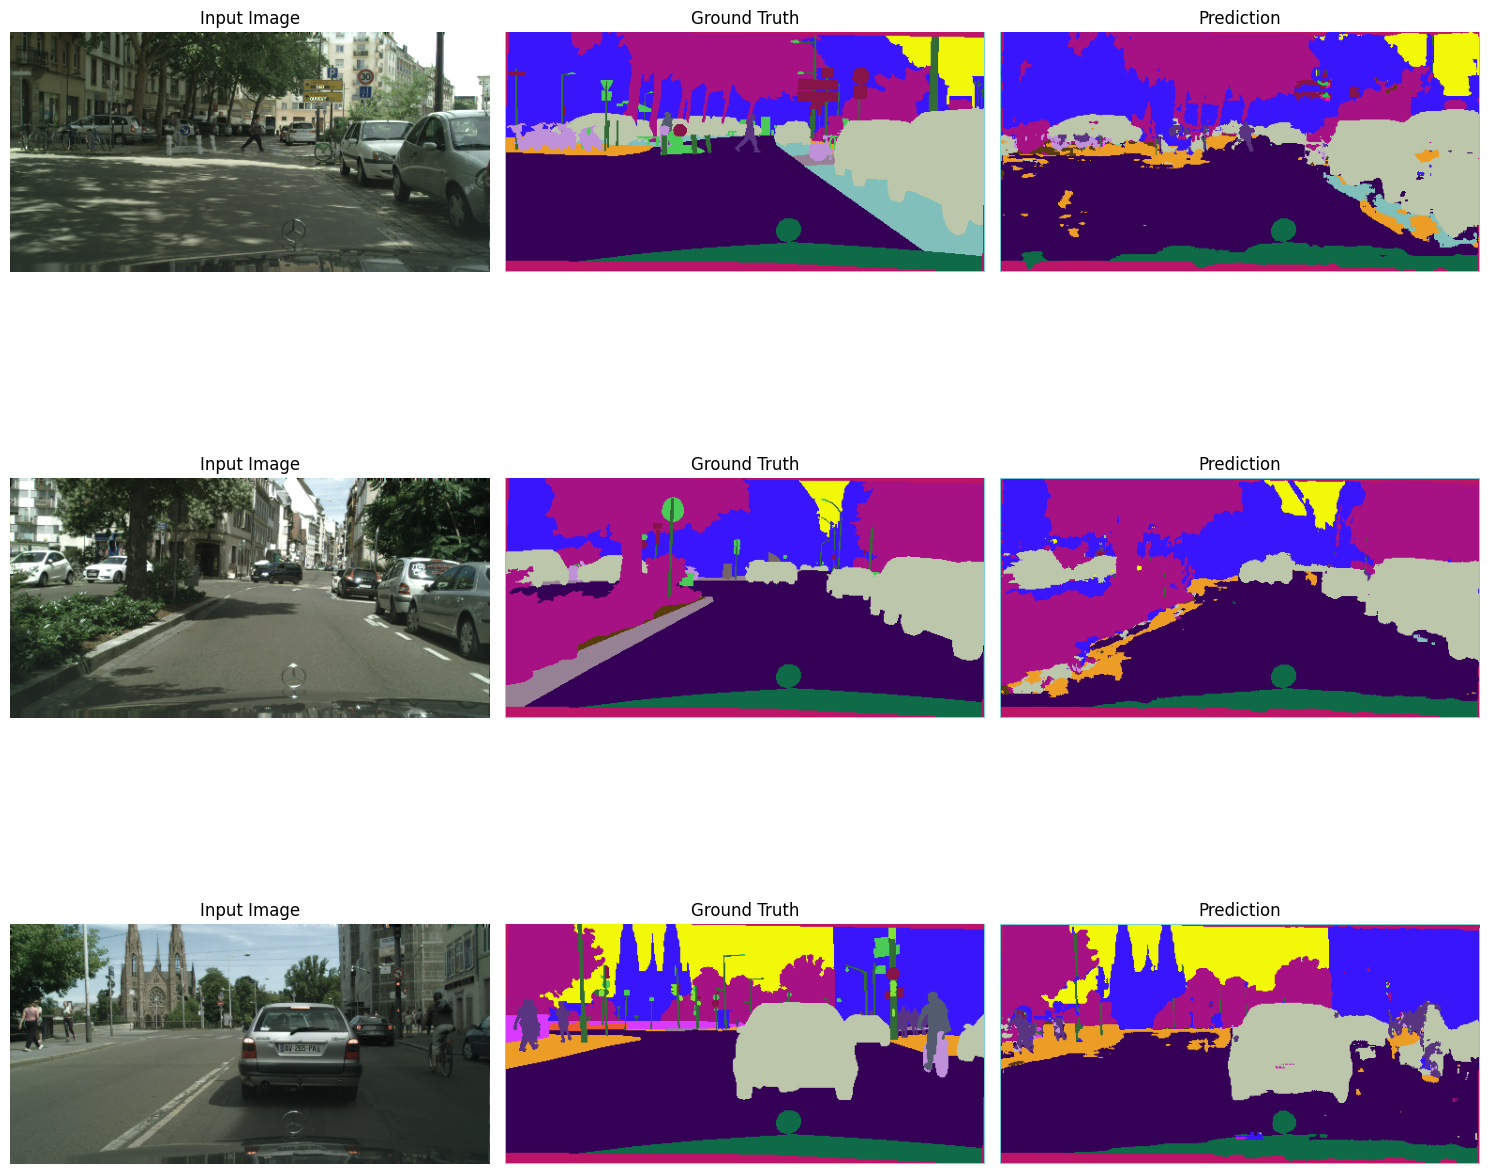

In [17]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_results(model, dataset, num_samples=3):
    # --- 1. 
    #  create 35 random colors (one for each class ID 0-34)
    
    np.random.seed(42)
    palette = np.random.randint(0, 255, size=(35, 3))
    
    plt.figure(figsize=(15, 5 * num_samples))
    
    # --- 2. Predict on Validation Data ---
    for i, (image, mask) in enumerate(dataset.take(num_samples)):
        # Predict: Input (1, 256, 512, 3) -> Output (1, 256, 512, 34)
        pred_prob = model.predict(image)
        
        # Convert Probabilities to Class IDs
        # Take the index with the highest probability
        pred_mask = tf.argmax(pred_prob, axis=-1) 
        
        # --- 3. Plotting ---
        # A. Original Image
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(image[0])
        plt.title("Input Image")
        plt.axis('off')
        
        # B. Ground Truth 
        plt.subplot(num_samples, 3, i * 3 + 2)
        # Squeeze removes the extra '1' dimension: (1, 256, 512) -> (256, 512)
        gt_img = palette[mask[0].numpy().squeeze()]
        plt.imshow(gt_img.astype(np.uint8))
        plt.title("Ground Truth")
        plt.axis('off')
        
        # C. Prediction 
        plt.subplot(num_samples, 3, i * 3 + 3)
        pred_img = palette[pred_mask[0].numpy().squeeze()]
        plt.imshow(pred_img.astype(np.uint8))
        plt.title("Prediction")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Run it!
visualize_results(unet, val_ds, num_samples=3)

In [18]:
# --- 1. Evaluate on Validation Set ---
print("📊 Calculating final metrics on Validation Data...")
results = unet.evaluate(test_ds)

print("-" * 30)
print(f"Final Test Loss:     {results[0]:.4f}")
print(f"Final Test Accuracy: {results[1]*100:.2f}%")
print("-" * 30)

# --- 2. Save the Model ---

unet.save('cityscapes_unet_final.keras')
print("💾 Model saved as 'cityscapes_unet_final.keras'")

📊 Calculating final metrics on Validation Data...
56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 315ms/step - accuracy: 0.7721 - loss: 0.8317
------------------------------
Final Test Loss:     0.7755
Final Test Accuracy: 78.94%
------------------------------
💾 Model saved as 'cityscapes_unet_final.keras'
